In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## First create models for actor and critic for both the agents in the environment

In [14]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [8]:
class Actor(nn.Module):
    """Actor Policy Model"""
    def __init__(self, state_size, action_size, seed, f1_units=512, f2_units=256):
        """
        Initialize parameters and build the model architecture
        Params
            state_size(int) : Dimension of each state
            action_size(int) : Dimension of each action
            seed(int) : Random seed
            f1_units(int) : number of nodes in first hidden layer
            f2_units(int) : number of nodes in second hidden layer
        """
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.f1 = nn.Linear(state_size, f1_units)
#         self.bn1 = nn.BatchNorm1d(f1_units)
        self.f2 = nn.Linear(f1_units, f2_units)
#         self.bn2 = nn.BatchNorm1d(f2_units)
        self.f3 = nn.Linear(f2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.f1.weight.data.uniform_(*hidden_init(self.f1))
        self.f2.weight.data.uniform_(*hidden_init(self.f2))
        self.f3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        """Build an Actor Policy network that gives best actions given an environment state"""
        x = F.relu(self.f1(state))
        x = F.relu(self.f2(x))
        return F.tanh(self.f3(x))

In [9]:
class Critic(nn.Module):
    """Critic Value Model"""
    def __init__(self, state_size, action_size, seed, f1_units=512, f2_units=256, dropout=0.2):
        """Initialize parameters and build the model
        Params
            state_size(int) : Dimension of each state
            action_size(int) : Dimension of each action
            seed(int) : Random seed
            f1_units(int) : number of nodes in first hidden layer
            f2_units(int) : number of nodes in second hidden layer
        """
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.f1 = nn.Linear(state_size, f1_units)
#         self.bn1 = nn.BatchNorm1d(f1_units)
        self.f2 = nn.Linear(f1_units+action_size, f2_units)
#         self.bn2 = nn.BatchNorm1d(f2_units)
        self.dropout = nn.Dropout(p=dropout)
        self.f3 = nn.Linear(f2_units, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.f1.weight.data.uniform_(*hidden_init(self.f1))
        self.f2.weight.data.uniform_(*hidden_init(self.f2))
        self.f3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Building a critic value network that gives Q value given state and action"""
        xs = F.relu(self.f1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.f2(x))
        x = self.dropout(x)
        return self.f3(x)

## Now creating Agent that would drive the agent for perform tasks and learn

In [19]:
# Setting hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
class Agent():
    """Interacts with and learns from the environment"""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network with its target network
        self.actor_active = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_active.parameters(), lr=LR_ACTOR)

        # Critic Network with its target network
        self.critic_active = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_active.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step_to_learn(self):
        """Use random sampling from replay memory to learn."""
        # Learn only if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
    
    def get_action_to_take(self, state):
        """Returns action for a given state as per policy learned so far"""
        state = torch.from_numpy(state).float().to(device)
        self.actor_active.eval()
        with torch.no_grad():
            action = self.actor_active(state).cpu().data.numpy()
        self.actor_active.train()
        action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using retrieved batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        
        # update the critic
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_active(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_active.parameters(), 1)
        self.critic_optimizer.step()
        
        # update the actor
        # first Compute actor loss
        actions_predicted = self.actor_active(states)
        actor_loss = -self.critic_active(states, actions_predicted).mean()
        # then minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # soft update the target networks
        self.soft_update(self.critic_active, self.critic_target, TAU)
        self.soft_update(self.actor_active, self.actor_target, TAU)
    
    def soft_update(self, active_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            active_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, active_param in zip(target_model.parameters(), active_model.parameters()):
            target_param.data.copy_(tau*active_param.data + (1.0-tau)*target_param.data)

In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [25]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [15]:
# Initialise the two agents
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=2)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=2)

## Train the agents

Both the agents can observe their local environments and are trained together using self play technique

In [21]:
def train_agents(n_episodes=1000, max_t=3000, update_every=10, num_learning_cycles=10):
    scores_deque = deque(maxlen=100)
    scores = []   

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.noise_reset()
        agent2.noise_reset()
        scores_per_episode = np.zeros(num_agents)
        for t in range(max_t):
            # extract the state of each agent
            state1 = states[0]
            state2 = states[1]
            state1 = state1.reshape((1,states.shape[1]))
            state2 = state2.reshape((1,states.shape[1]))
            action1 = agent1.get_action_to_take(state1)
            action2 = agent2.get_action_to_take(state2)
            # send actions to the environment 
            env_info = env.step([action1, action2])[brain_name] 
            # get next states
            next_states = env_info.vector_observations   
            # get rewards
            rewards = env_info.rewards    
            # see if episodes finished
            dones = env_info.local_done
            
            # add experiences to shared replay memory
            for state, action, reward, next_state, done in zip(states, [action1, action2], rewards, next_states, dones):
                agent1.memory.add(state, action, reward, next_state, done)
                agent2.memory.add(state, action, reward, next_state, done)            
            
            # update the networks for 'num_learning_cycles' consecutive times every 'update_every' time steps
            if t % update_every == 0:
                for _ in range(num_learning_cycles):
                    agent1.step_to_learn()
                    agent2.step_to_learn()
                    
            # roll over states to next time step
            states = next_states
            #update the scores per episode
            scores_per_episode += rewards
            
            # exit loop if all episodes have completed
            if np.all(dones):
                break 
        
        score_max = np.max([scores_per_episode[0], scores_per_episode[1]])
        scores_deque.append(score_max)
        scores.append(score_max)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score_max))
        if i_episode % 100 == 0:            
            print("-----------------------------------------------------")   
        if (np.mean(scores_deque)>=0.5) & (i_episode > 100):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_active.state_dict(), 'actor_1_done.pth')
            torch.save(agent1.critic_active.state_dict(), 'critic_1_done.pth')
            torch.save(agent2.actor_active.state_dict(), 'actor_2_done.pth')
            torch.save(agent2.critic_active.state_dict(), 'critic_2_done.pth')
            break
    return scores

Episode 1	Average Score: 0.00	Score: 0.00
Episode 2	Average Score: 0.00	Score: 0.00
Episode 3	Average Score: 0.00	Score: 0.00
Episode 4	Average Score: 0.00	Score: 0.00
Episode 5	Average Score: 0.00	Score: 0.00
Episode 6	Average Score: 0.00	Score: 0.00
Episode 7	Average Score: 0.00	Score: 0.00
Episode 8	Average Score: 0.00	Score: 0.00
Episode 9	Average Score: 0.00	Score: 0.00
Episode 10	Average Score: 0.00	Score: 0.00
Episode 11	Average Score: 0.00	Score: 0.00
Episode 12	Average Score: 0.00	Score: 0.00
Episode 13	Average Score: 0.00	Score: 0.00
Episode 14	Average Score: 0.00	Score: 0.00
Episode 15	Average Score: 0.00	Score: 0.00
Episode 16	Average Score: 0.00	Score: 0.00
Episode 17	Average Score: 0.00	Score: 0.00
Episode 18	Average Score: 0.01	Score: 0.10
Episode 19	Average Score: 0.01	Score: 0.00
Episode 20	Average Score: 0.01	Score: 0.00
Episode 21	Average Score: 0.00	Score: 0.00
Episode 22	Average Score: 0.00	Score: 0.00
Episode 23	Average Score: 0.00	Score: 0.00
Episode 24	Average S

Episode 189	Average Score: 0.01	Score: 0.00
Episode 190	Average Score: 0.01	Score: 0.00
Episode 191	Average Score: 0.01	Score: 0.10
Episode 192	Average Score: 0.01	Score: 0.00
Episode 193	Average Score: 0.01	Score: 0.10
Episode 194	Average Score: 0.01	Score: 0.00
Episode 195	Average Score: 0.01	Score: 0.00
Episode 196	Average Score: 0.01	Score: 0.00
Episode 197	Average Score: 0.01	Score: 0.00
Episode 198	Average Score: 0.01	Score: 0.00
Episode 199	Average Score: 0.01	Score: 0.00
Episode 200	Average Score: 0.01	Score: 0.00
-----------------------------------------------------
Episode 201	Average Score: 0.01	Score: 0.00
Episode 202	Average Score: 0.01	Score: 0.00
Episode 203	Average Score: 0.01	Score: 0.00
Episode 204	Average Score: 0.01	Score: 0.00
Episode 205	Average Score: 0.01	Score: 0.20
Episode 206	Average Score: 0.01	Score: 0.10
Episode 207	Average Score: 0.02	Score: 0.30
Episode 208	Average Score: 0.02	Score: 0.10
Episode 209	Average Score: 0.02	Score: 0.00
Episode 210	Average Sc

Episode 373	Average Score: 0.15	Score: 0.40
Episode 374	Average Score: 0.16	Score: 0.30
Episode 375	Average Score: 0.16	Score: 0.50
Episode 376	Average Score: 0.16	Score: 0.19
Episode 377	Average Score: 0.16	Score: 0.30
Episode 378	Average Score: 0.17	Score: 0.60
Episode 379	Average Score: 0.18	Score: 0.90
Episode 380	Average Score: 0.19	Score: 1.00
Episode 381	Average Score: 0.19	Score: 0.20
Episode 382	Average Score: 0.19	Score: 0.20
Episode 383	Average Score: 0.19	Score: 0.30
Episode 384	Average Score: 0.19	Score: 0.40
Episode 385	Average Score: 0.19	Score: 0.10
Episode 386	Average Score: 0.20	Score: 0.70
Episode 387	Average Score: 0.20	Score: 0.00
Episode 388	Average Score: 0.20	Score: 0.00
Episode 389	Average Score: 0.20	Score: 0.19
Episode 390	Average Score: 0.20	Score: 0.20
Episode 391	Average Score: 0.20	Score: 0.20
Episode 392	Average Score: 0.21	Score: 0.70
Episode 393	Average Score: 0.22	Score: 0.90
Episode 394	Average Score: 0.24	Score: 2.00
Episode 395	Average Score: 0.24	

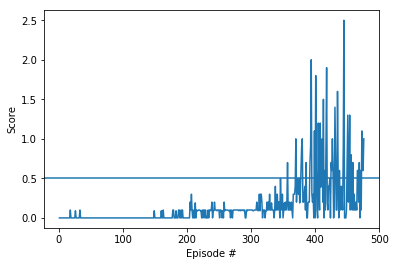

In [22]:
# now train the agents
scores = train_agents()

# plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axhline(y=0.5, xmin=0, xmax=len(scores)+1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()